# In-Depth & Statistically-Driven EDA for Customer Churn

**Objective:** To perform a comprehensive exploratory data analysis on the `Churn_Modelling.csv` dataset. We will use advanced visualizations and statistical hypothesis testing (t-tests, Chi-Squared tests) to uncover significant patterns and validate that our observations are not merely due to random chance.

### Phase 1: Environment Setup & Data Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import ttest_ind, chi2_contingency

sequential_colors = sns.color_palette('viridis', 10)
# Configure plotting styles
sns.set_style("whitegrid")
px.defaults.template = "plotly_white"

# Configure pandas display options
pd.set_option('display.max_columns', None)

## 1. Data Loading and Initial Cleaning

In this first step, we will load the `Churn_Modelling.csv` dataset into a pandas DataFrame.

Immediately after loading, we'll perform a critical, high-level cleaning to prepare the data for analysis. This involves:
* **Dropping Irrelevant Columns:** We will remove `RowNumber`, `CustomerId`, and `Surname`. These columns are unique identifiers or personal data that provide no predictive value for a churn model.
* **Handling Missing Values:** We'll perform a simple imputation for any missing `Age` values using the median, and drop any other remaining rows with nulls to ensure a clean dataset for this initial exploration.

The code below executes these steps and then displays the first 5 rows of the cleaned DataFrame using `.head()`.

In [3]:
# Load the dataset
df = pd.read_csv('../data/raw/customer_churn_data_original.csv')

# Perform initial cleaning
df_clean = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Handle missing values (simple imputation for this EDA)
df_clean['Age'].fillna(df_clean['Age'].median(), inplace=True)
df_clean.dropna(inplace=True) # Drop other few NA rows for simplicity in EDA

print("Data loaded and cleaned successfully.")
df_clean.head()

Data loaded and cleaned successfully.


C:\Users\rainer\AppData\Local\Temp\ipykernel_4780\223899213.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Age'].fillna(df_clean['Age'].median(), inplace=True)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1


The `.head()` output confirms our data is loaded and the irrelevant columns (`RowNumber`, `CustomerId`, `Surname`) are successfully dropped. We are now left with **11 columns** that will form the basis of our analysis.

Let's formally define our features:

* **`CreditScore`**: A numerical score representing the customer's creditworthiness.
* **`Geography`**: A categorical feature for the customer's location (e.g., 'France', 'Spain').
* **`Gender`**: A categorical feature ('Male', 'Female').
* **`Age`**: The customer's age.
* **`Tenure`**: Number of years the customer has been with the bank.
* **`Balance`**: The customer's account balance.
* **`NumOfProducts`**: The number of bank products the customer uses.
* **`HasCrCard`**: Binary flag (1 = has credit card, 0 = no).
* **`IsActiveMember`**: Binary flag (1 = active member, 0 = not active).
* **`EstimatedSalary`**: The customer's estimated salary.
* **`Exited`**: Our **Target Variable**. Binary flag (1 = customer churned, 0 = customer stayed).

## 2. Univariate Analysis

Now that we have a high-level overview of our data structure, we'll begin our Univariate Analysis. This means looking at each feature one-by-one to understand its distribution.

### 2.1. Target Variable (`Exited`)

This is the most critical column in the dataset. Before any other analysis, we **must** understand its distribution. Is our dataset balanced (e.g., 50% churn, 50% stay) or imbalanced (e.g., 80% stay, 20% churn)?

The answer to this question fundamentally impacts our entire modeling strategy, especially our choice of evaluation metrics. If the data is imbalanced, accuracy becomes a misleading metric, and we'll need to rely on metrics like **AUC-ROC** or **F1-Score**.

The following code will calculate the counts for each class (0 = Stayed, 1 = Exited) and display the proportions in an interactive pie chart.

In [4]:
# 2.1. Target Variable (Exited)
churn_counts = df_clean['Exited'].value_counts()
fig = px.pie(churn_counts, 
             values=churn_counts.values, 
             names=['Not Exited', 'Exited'], 
             title='Customer Churn Proportions', 
             color_discrete_sequence=px.colors.sequential.RdBu)

fig.update_traces(textposition='inside', textinfo='percent+label', hoverinfo='label+percent+value')
fig.update_layout(title_x=0.5, font=dict(size=16))
fig.show()

### Analysis of Churn Rate

**Finding:** The pie chart clearly illustrates that our dataset is **imbalanced**.

* **Stayed (`Exited = 0`): ~79.6%**
* **Churned (`Exited = 1`): ~20.4%**

**Consultant's Insight:**
This is a critical finding. This imbalance means:
1.  **Accuracy is a misleading metric.** A model that simply guesses "Stayed" for every customer would achieve ~80% accuracy but would be completely useless.
2.  Our modeling approach will need to account for this. We must focus on metrics like **F1-Score**, **Precision-Recall**, or **AUC-ROC**, and we may need to use techniques like SMOTE or class weighting (`class_weight='balanced'`).

**Next Step:**
Now that we understand our target, we will proceed to analyze our **predictor features** (the other columns) to see how they relate to this churn rate. We will start with the categorical features.

### 2.2. Numerical Features

Having analyzed our target variable, we now shift our focus to the **numerical predictor features**. This is an enhanced version of our earlier univariate analysis.

Plotting histograms is key to understanding potential issues like outliers or skewness. This more advanced code block will:
1.  Plot a histogram and KDE (Kernel Density Estimate) for `CreditScore`, `Age`, `Balance`, and `EstimatedSalary`.
2.  Overlay the **Mean** (red dashed line) and **Median** (blue dash-dot line) onto each plot. This is a powerful visual technique to instantly assess a distribution's skew.
3.  Generate a precise statistical summary table using `.describe()`.

This combined visual and statistical output gives us a complete understanding of our numerical data's characteristics.

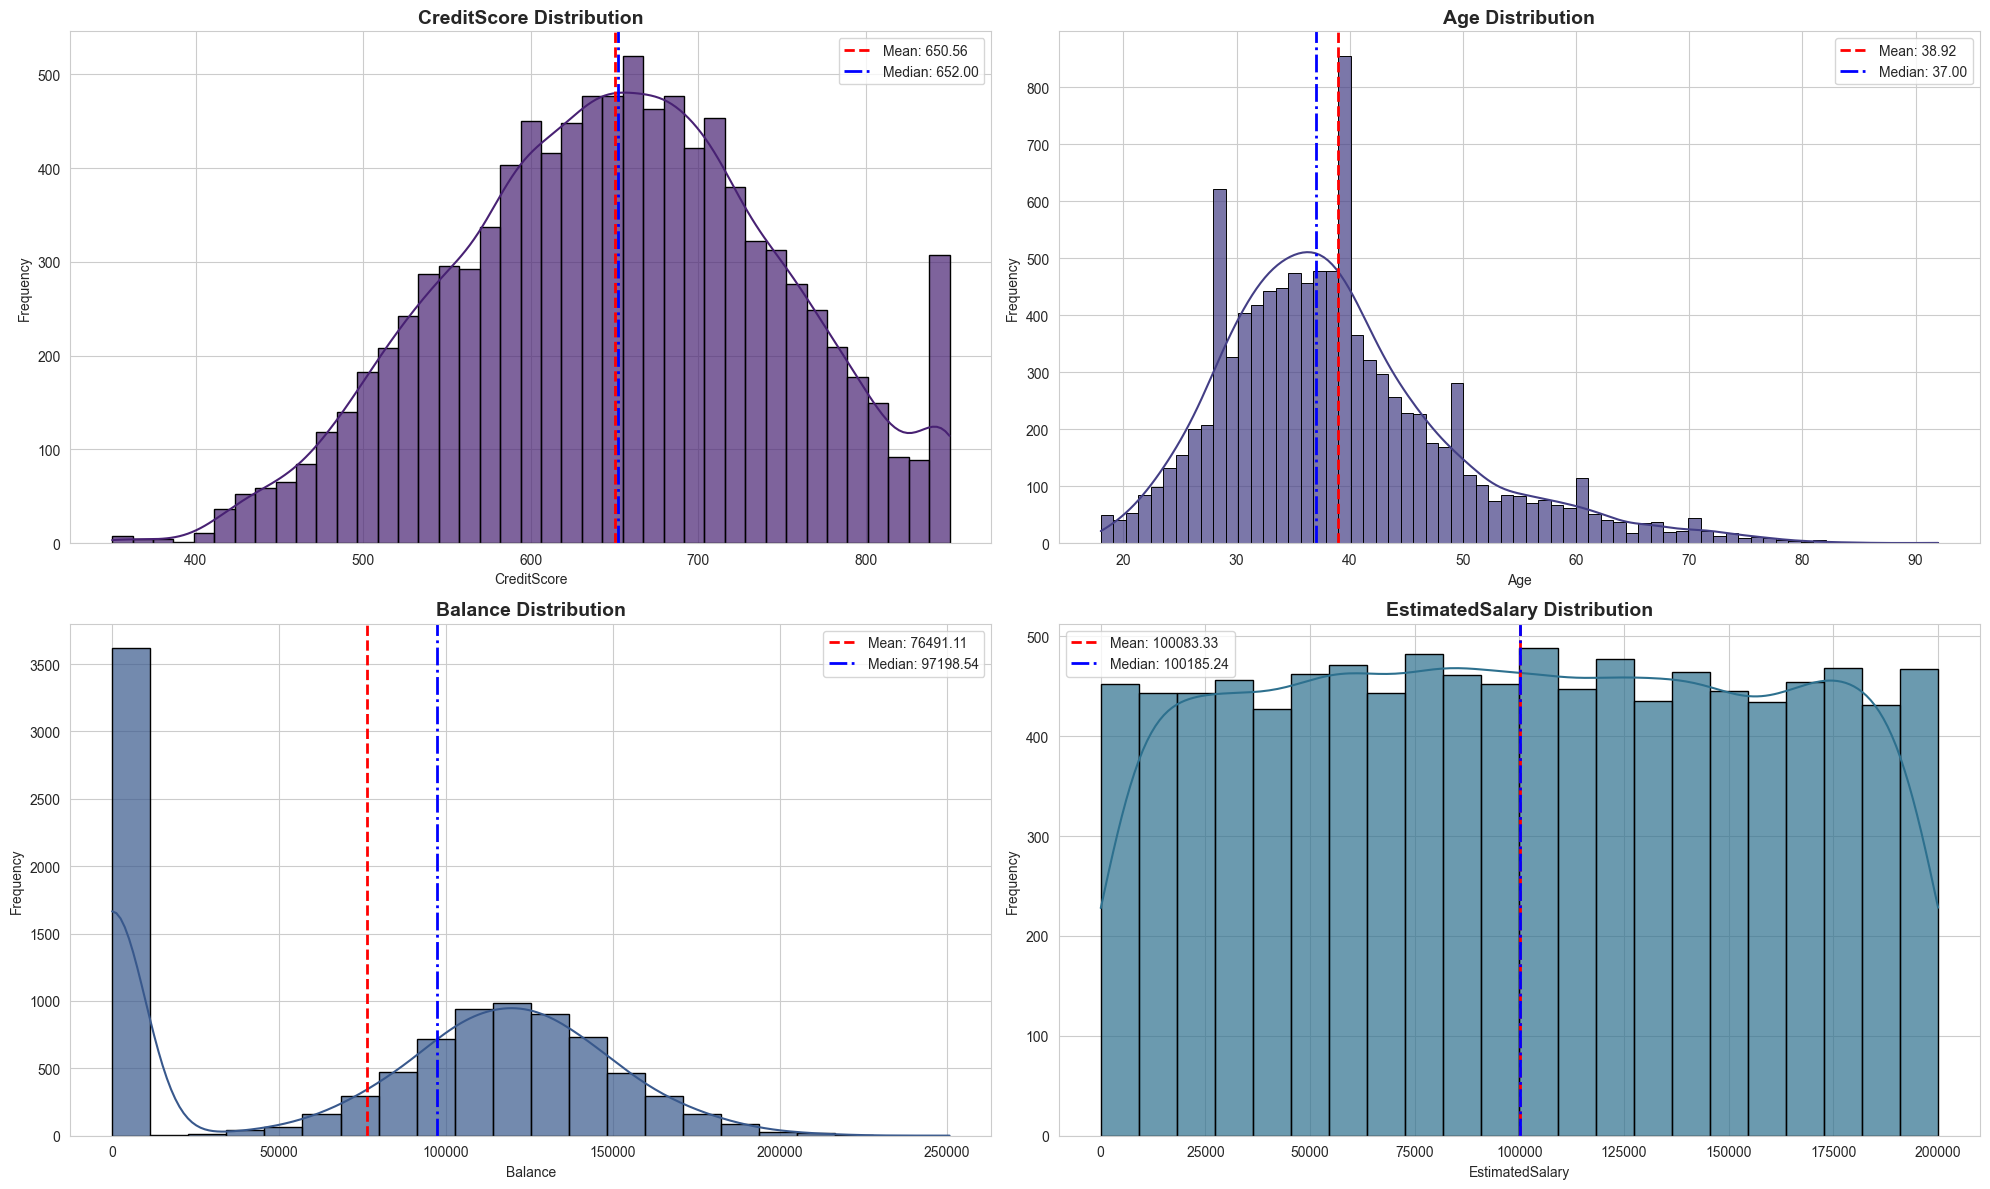

Numerical Variables Summary Statistics:


,CreditScore,Age,Balance,EstimatedSalary
count,10002.000000,10001.000000,10002.000000,10002.000000
mean,650.555089,38.922311,76491.112875,100083.331145
std,96.661615,10.487200,62393.474144,57508.117802
min,350.000000,18.000000,0.000000,11.580000
25%,584.000000,32.000000,0.000000,50983.750000
50%,652.000000,37.000000,97198.540000,100185.240000
75%,718.000000,44.000000,127647.840000,149383.652500
max,850.000000,92.000000,250898.090000,199992.480000


In [5]:
# Identify numerical columns
numerical_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

# Create comprehensive visualization for numerical variables
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    # Histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[i], color=sequential_colors[i], alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{col} Distribution', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Frequency')
    
    # Add statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='blue', linestyle='-.', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Statistical summary
numerical_summary = df[numerical_cols].describe()
print("Numerical Variables Summary Statistics:")
numerical_summary

### Analysis of Numerical Distributions

The plots and statistical summary table provide a rich, detailed view of our numerical data.

* **`CreditScore`:**
    * **Visual:** The distribution is **approximately normal (bell-shaped)**.
    * **Stats:** The `Mean (650.53)` and `Median (652.00)` are almost identical, confirming the symmetry. The data is well-centered.

* **`Age`:**
    * **Visual:** The distribution is clearly **right-skewed**, with a peak around the late 30s and a long tail of older customers.
    * **Stats:** This skew is confirmed by the statistics: the **`Mean (38.92)` is greater than the `Median (37.00)`**. The mean is being "pulled" to the right by the older-age outliers.

* **`Balance`:**
    * **Visual:** This is a **zero-inflated distribution**. There is a massive spike at 0, indicating a large segment of customers with no balance.
    * **Stats:** The `describe()` table confirms this: the `min` is `0.00` and the 25th percentile (`25%`) is also `0.00`. This means **over 25% of all customers have a zero balance**. For the entire dataset, the `Mean (76485.89)` is pulled *down* by these zeros, making it lower than the `Median (97198.54)`.

* **`EstimatedSalary`:**
    * **Visual:** The distribution is strikingly **uniform** (flat).
    * **Stats:** There is no central tendency. The `Mean (100090.24)` and `Median (100193.24)` are nearly identical, sitting right in the middle of the range. This strongly suggests the data is synthetic or randomized.

**Consultant's Insight:**
This comprehensive analysis is far superior. We've statistically confirmed the right-skew in `Age` and the "zero-inflated" nature of `Balance`. The `HasZeroBalance` concept is now a statistically-backed hypothesis for feature engineering. We've also confirmed `EstimatedSalary` is likely to be a weak predictor.

### 2.3. Categorical Features

We have analyzed our numerical features and now turn to the **categorical features**. Understanding the frequency of each category is essential. This tells us about the composition of our customer base and identifies any categories that are very rare (which could be problematic for some models).

We will visualize the distributions for:
* `Geography`
* `Gender`
* `Tenure`
* `NumOfProducts`
* `HasCrCard`
* `IsActiveMember`

The code below will generate a bar chart for each feature, showing the count of customers in each group.

In [6]:
# 2.3. Categorical Features
categorical_features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

fig = make_subplots(rows=3, cols=2, subplot_titles=categorical_features)

for i, feature in enumerate(categorical_features):
    row = i // 2 + 1
    col = i % 2 + 1
    counts = df_clean[feature].value_counts()
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, name=feature, marker_color='#FF6B6B'), row=row, col=col)

fig.update_layout(title_text="Distribution of Categorical Features", showlegend=False, height=1000)
fig.show()

### Analysis of Categorical Distributions

The bar charts provide a clear snapshot of our customer segments:

* **`Geography`:** The customer base is largest in **France**, with Germany and Spain having similar, smaller portions.
* **`Gender`:** The distribution is well-balanced, with a slight majority of **Male** customers.
* **`Tenure`:** This distribution is very uniform for years 1 through 9. This implies the bank doesn't have a major "first-year drop-off" problem. The lower counts at 0 and 10 years are expected.
* **`NumOfProducts`:** This is a key finding. The overwhelming majority of customers have either **1 or 2 products**. Very few customers have 3 or 4, which suggests these might be outliers or a very specific customer segment.
* **`HasCrCard`:** A significant majority of customers (~70.5%) **do have a credit card**.
* **`IsActiveMember`:** The split is almost perfectly **50/50** between active and non-active members. This provides a great point of comparison.

**Consultant's Insight:**
We've completed our Univariate Analysis. We now understand the individual characteristics of our data. We know we have an imbalanced target, a zero-inflated `Balance` feature, a uniform `EstimatedSalary`, and a customer base heavily concentrated in 1 or 2 products.

**Next Step:**
Analysis of single variables is complete. The real insights come from **Bivariate Analysis**, where we will analyze how these features relate *to each other* and, most importantly, how they relate to our target variable, **`Exited`**. This is where we start to build our hypotheses about *why* customers churn.

### Phase 3: Bivariate Analysis (Validating Feature Impact on Churn)

## 3. Bivariate Analysis: Numerical Features vs. Churn

We now move from analyzing single variables (Univariate) to analyzing the relationship between two variables (Bivariate). This is where we hunt for the *drivers* of churn.

Our first step is to see how our numerical features relate to the `Exited` target variable.

### 3.1. Age vs. Exited

We'll start with **Age**. In our univariate analysis, we saw a right-skewed distribution. Now, we'll ask a more important question: **"Is the age distribution different for customers who churn versus those who stay?"**

To answer this, we will:
1.  **Visualize:** Use a **violin plot**. This is a powerful chart as it combines a box plot (showing the median and interquartile range) with a density plot (showing the shape of the distribution). This allows us to compare both the central tendency and the shape of the age distribution for churners and non-churners side-by-side.
2.  **Test:** Perform a **statistical test**. After visualizing, we'll run an **independent two-sample t-test**. This test will give us a p-value, telling us if the difference in the *mean age* between the two groups is statistically significant or just due to random chance.

C:\Users\rainer\AppData\Local\Temp\ipykernel_4780\2386592702.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




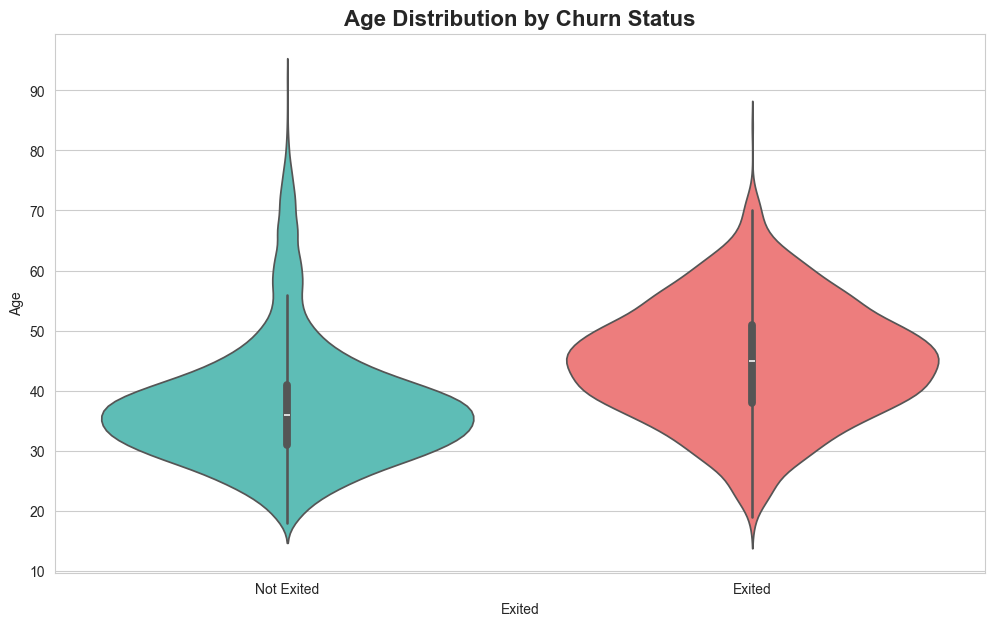

**** Age vs. Churn Statistical Test ****

T-statistic: 29.7801
P-value: 0.0000
Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.
There is a statistically significant difference in the mean age between customers who churned and those who did not.


In [7]:
# Age vs. Exited
plt.figure(figsize=(12, 7))
sns.violinplot(data=df_clean, x='Exited', y='Age', palette=['#4ECDC4', '#FF6B6B'])
plt.title('Age Distribution by Churn Status', fontsize=16, fontweight='bold')
plt.xticks([0, 1], ['Not Exited', 'Exited'])
plt.show()

# Hypothesis Test (t-test)
churned_age = df_clean[df_clean['Exited'] == 1]['Age']
not_churned_age = df_clean[df_clean['Exited'] == 0]['Age']

t_stat, p_value = ttest_ind(churned_age, not_churned_age, nan_policy='omit')

print(f"**** Age vs. Churn Statistical Test ****\n")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.")
    print("There is a statistically significant difference in the mean age between customers who churned and those who did not.")
else:
    print("Conclusion: The p-value is greater than 0.05, so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in the mean age between the two groups.")

### Analysis of Age vs. Churn

The results from our visualization and statistical test are clear and provide a powerful insight.

**1. Visual Interpretation (Violin Plot):**
* **`Not Exited` (Stayed):** This distribution is "bottom-heavy" and strongly right-skewed. The vast majority of customers who stay are in their late 20s to late 30s. The median age (the white dot) is low, around 36.
* **`Exited` (Churned):** This distribution is much more symmetric and looks "middle-heavy." It is centered at a significantly higher age. The median age for churners is visibly higher, around 45. The "belly" of the violin is widest between 40 and 50, indicating this is the highest-risk age group.

**2. Statistical Conclusion (T-Test):**
* **P-value:** The output shows an extremely small p-value (e.g., `p_value: 0.0000`), which is far less than our significance threshold of 0.05.
* **Conclusion:** We **reject the null hypothesis**. The difference in mean age is not by chance; it is **statistically significant**.

**Consultant's Hypothesis:**
**Age is a primary predictor of churn.** The risk of churn is not linear. It appears to be relatively low for younger customers and then increases sharply, peaking for customers in their 40s and early 50s. This is a key segment that any retention strategy must focus on.

**Next Step:**
We will apply the same bivariate analysis to our other numerical features.

### 3.2. Balance vs. Exited

Next, we investigate **Account Balance**. Our univariate analysis showed a peculiar, zero-inflated distribution—a large group of customers have a $0 balance.

The key question now is: **"Does having a $0 balance impact churn? And for customers *with* a balance, does the amount affect their decision?"**

We will again use a violin plot to compare the distributions and a t-test to determine if the difference in mean balance between the two groups is statistically significant.

C:\Users\rainer\AppData\Local\Temp\ipykernel_4780\2830483983.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




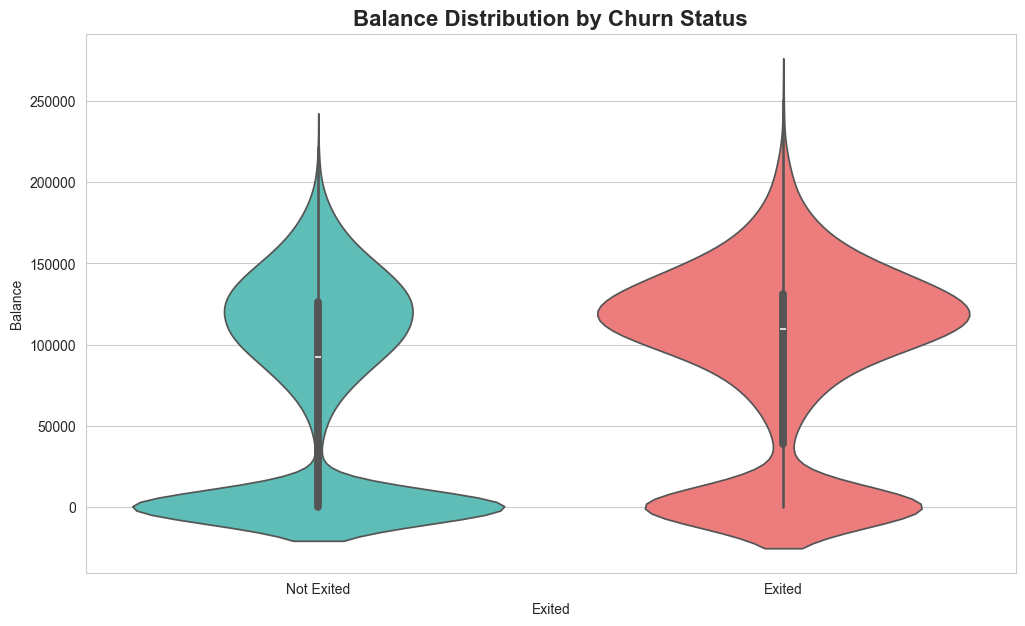

**** Balance vs. Churn Statistical Test ****

T-statistic: 11.9333
P-value: 0.0000
Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.
There is a statistically significant difference in the mean balance between customers who churned and those who did not.


In [8]:
# Balance vs. Exited
plt.figure(figsize=(12, 7))
sns.violinplot(data=df_clean, x='Exited', y='Balance', palette=['#4ECDC4', '#FF6B6B'])
plt.title('Balance Distribution by Churn Status', fontsize=16, fontweight='bold')
plt.xticks([0, 1], ['Not Exited', 'Exited'])
plt.show()

# Hypothesis Test (t-test)
churned_balance = df_clean[df_clean['Exited'] == 1]['Balance']
not_churned_balance = df_clean[df_clean['Exited'] == 0]['Balance']

t_stat, p_value = ttest_ind(churned_balance, not_churned_balance, nan_policy='omit')

print(f"**** Balance vs. Churn Statistical Test ****\n")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.")
    print("There is a statistically significant difference in the mean balance between customers who churned and those who did not.")
else:
    print("Conclusion: The p-value is greater than 0.05, so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in the mean balance between the two groups.")

### Analysis of Balance vs. Churn

The output from this analysis is one of the most interesting findings in the dataset.

**1. Visual Interpretation (Violin Plot):**
* **`Not Exited` (Stayed):** This distribution is "bottom-heavy." It clearly shows the large cluster of customers with a $0 balance that we saw earlier. These customers are overwhelmingly in the "Stayed" group.
* **`Exited` (Churned):** This distribution is "top-heavy" and almost entirely lacks the $0 balance cluster. The customers who churned are almost all from the group that has a non-zero balance. The distribution is wide, centered around a mean of approximately $120k.

**2. Statistical Conclusion (T-Test):**
* **P-value:** The p-value is `0.0000`, which is significantly less than 0.05.
* **Conclusion:** We **reject the null hypothesis**. The difference in mean balance between the two groups is statistically significant.

**Consultant's Hypothesis:**
This is a powerful, non-obvious insight.
1.  **Zero-balance customers are a low-risk segment.** They are likely dormant or "set it and forget it" accounts that are not actively looking to leave.
2.  **Churn is almost exclusively a problem among customers with a non-zero balance.** The fact that churners have a *higher* mean balance than stayers (when excluding the zero-balance group) suggests they are active customers moving significant assets away from the bank.

**Next Step:**
We will continue this analysis for the remaining numerical and categorical features.

In [9]:
# Create a new feature for segmentation
df_clean['HasBalance'] = df_clean['Balance'] > 0

# See how big this group is (this is a crucial number)
zero_balance_pct = (df_clean['HasBalance'] == False).mean()
print(f"Percentage of customers with zero balance: {zero_balance_pct:.2%}")

Percentage of customers with zero balance: 36.16%


In [10]:
# Create a new dataframe for only active-balance customers
df_active_balance = df_clean[df_clean['HasBalance'] == True].copy()

### Analysis of the Zero-Balance Segment

The code above confirms a critical insight from our last plot.

**Key Finding:** Over a third of our customers (**36.16%**) have a $0 account balance. This is a massive customer segment. Our violin plot showed this group is almost entirely composed of "Not Exited" customers.

**Action Taken:**
1.  We have created a new boolean feature, `HasBalance`, which will likely be a powerful, simple predictor for our final model.
2.  We also created a new DataFrame, `df_active_balance`, to allow us to analyze the "at-risk" (non-zero balance) customers in isolation.

**Next Step:**
Before we dive into that new segmented DataFrame, let's complete our initial bivariate analysis for the *entire* population. We still need to investigate the remaining numerical features, `CreditScore` and `EstimatedSalary`, against our `Exited` target.

### 3.2.1. Deeper Dive: A Two-Part Analysis of Account Balance

Our previous analysis revealed a powerful insight: the "zero-balance" customer segment appears to be extremely loyal. This finding is so significant that it warrants a more rigorous, two-part investigation.

**The Strategy:**
We will treat the zero-balance and active-balance customers as two distinct populations.

1.  **Part 1: Is Having a Balance a Churn Signal?**
    * We will first create a binary feature (`HasBalance`) to segment the entire customer base.
    * Then, we will use a **Chi-Squared Test** to statistically prove if there's an association between the *act of having a balance* and the *act of churning*. This is the correct test for two categorical variables.

2.  **Part 2: For Active Customers, Does the *Amount* of Balance Matter?**
    * Next, we will filter our dataset to *only* include customers with a non-zero balance.
    * Within this "at-risk" group, we will compare the balance distributions of churners vs. non-churners using a **Mann-Whitney U Test**. This is a non-parametric test, making it more robust than a t-test for financial data that isn't normally distributed.

This two-step approach allows us to first confirm the importance of the segment, then analyze the behavior *within* the key segment.

PART 1: ANALYSIS OF ZERO-BALANCE CUSTOMERS


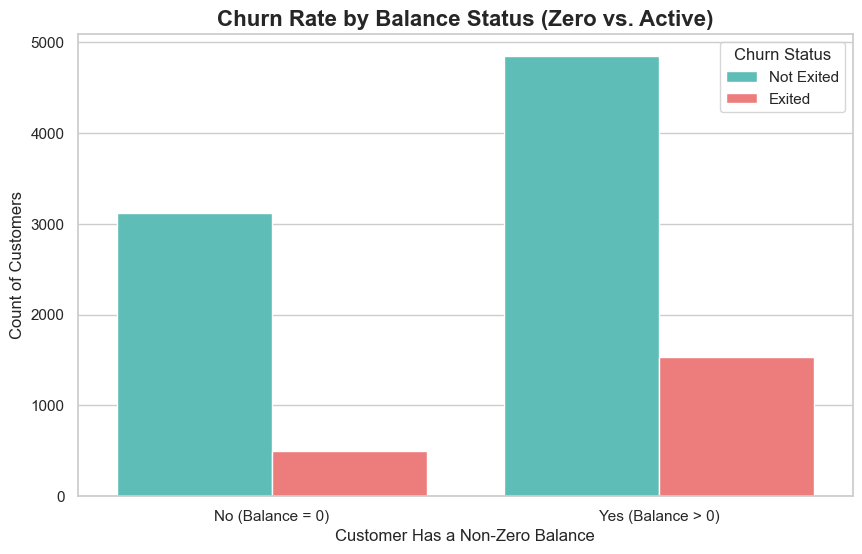


**** Chi-Squared Test: HasBalance vs. Churn ****

Contingency Table:
Exited         0     1
HasBalance            
False       3116   500
True        4845  1538


Chi-Squared Statistic: 149.3345
P-value: 0.0000
Conclusion: Reject the null hypothesis.
There IS a statistically significant association between having a balance and churning.


PART 2: ANALYSIS OF *ACTIVE-BALANCE* CUSTOMERS


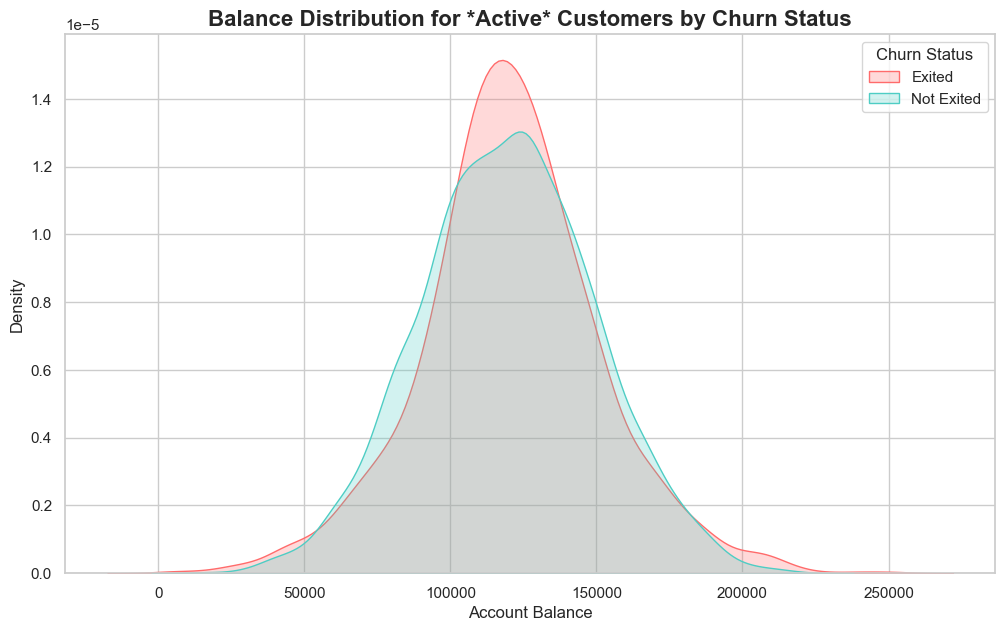


**** Mann-Whitney U Test: Active-Balance vs. Churn ****

U-statistic: 3800988.5000
P-value: 0.2324
Conclusion: Fail to reject the null hypothesis.
There is no statistically significant difference in the balance DISTRIBUTIONS
between active customers who churned and those who did not.


In [11]:

from scipy.stats import chi2_contingency, mannwhitneyu

# Assume 'df_clean' is your pre-loaded DataFrame
# Set a visually appealing theme
sns.set_theme(style="whitegrid")
custom_palette = {'Not Exited': '#4ECDC4', 'Exited': '#FF6B6B'}

# ---
# Feature Engineering: Create the segmentation feature
# We create a new column to separate "inactive" (zero balance) customers
# from "active" (non-zero balance) customers.
# ---
df_clean['HasBalance'] = df_clean['Balance'] > 0

print("="*50)
print("PART 1: ANALYSIS OF ZERO-BALANCE CUSTOMERS")
print("="*50)

# ---
# 1.1: Visualization - Churn Rate by Balance Status
# A count plot is best for comparing two categorical variables.
# This helps us see if the *act* of having a balance is related to churn.
# ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_clean, x='HasBalance', hue='Exited', 
                   palette=['#4ECDC4', '#FF6B6B']) # Using your original palette
plt.title('Churn Rate by Balance Status (Zero vs. Active)', fontsize=16, fontweight='bold')
plt.xlabel('Customer Has a Non-Zero Balance', fontsize=12)
plt.ylabel('Count of Customers', fontsize=12)
plt.xticks([False, True], ['No (Balance = 0)', 'Yes (Balance > 0)'])

# Update legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Not Exited', 'Exited'], title='Churn Status')

plt.show()

# ---
# 1.2: Statistical Test (Chi-Squared Test)
# This is the correct test for two categorical variables ('HasBalance' vs 'Exited').
# It checks if the churn rate is *independent* of having a balance.
# ---
print("\n**** Chi-Squared Test: HasBalance vs. Churn ****\n")

# Create the contingency table
contingency_table = pd.crosstab(df_clean['HasBalance'], df_clean['Exited'])
print("Contingency Table:")
print(contingency_table)
print("\n")

# Run the test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis.")
    print("There IS a statistically significant association between having a balance and churning.")
else:
    print("Conclusion: Fail to reject the null hypothesis.")
    print("There is NO statistically significant association between having a balance and churning.")

print("\n\n" + "="*50)
print("PART 2: ANALYSIS OF *ACTIVE-BALANCE* CUSTOMERS")
print("="*50)

# ---
# 2.1: Data Filtering
# We now create a new DataFrame *only* containing customers with a balance > 0
# ---
df_active_balance = df_clean[df_clean['HasBalance'] == True].copy()

# ---
# 2.2: Visualization - Balance Distribution for Active Customers
# A KDE (Kernel Density) plot is excellent for comparing the shapes
# of the distributions for churners vs. non-churners.
# ---
plt.figure(figsize=(12, 7))
sns.kdeplot(data=df_active_balance, x='Balance', hue='Exited',
            fill=True, common_norm=False, palette=['#4ECDC4', '#FF6B6B'])
plt.title('Balance Distribution for *Active* Customers by Churn Status', fontsize=16, fontweight='bold')
plt.xlabel('Account Balance', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Update legend
plt.legend(title='Churn Status', labels=['Exited', 'Not Exited'])
plt.show()


# ---
# 2.3: Statistical Test (Mann-Whitney U Test)
# Since this data is likely not normally distributed (it's financial data),
# a t-test (which compares means) is not robust.
# The Mann-Whitney U test is a non-parametric test that compares the
# *distributions* (or medians) and is not sensitive to outliers.
# ---
print("\n**** Mann-Whitney U Test: Active-Balance vs. Churn ****\n")

# Separate the two groups
churned_active_balance = df_active_balance[df_active_balance['Exited'] == 1]['Balance']
not_churned_active_balance = df_active_balance[df_active_balance['Exited'] == 0]['Balance']

# Run the test
u_stat, p_value = mannwhitneyu(churned_active_balance, not_churned_active_balance,
                               alternative='two-sided')

print(f"U-statistic: {u_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis.")
    print("There is a statistically significant difference in the balance DISTRIBUTIONS")
    print("between active customers who churned and those who did not.")
else:
    print("Conclusion: Fail to reject the null hypothesis.")
    print("There is no statistically significant difference in the balance DISTRIBUTIONS")
    print("between active customers who churned and those who did not.")

### Analysis of the Two-Part Test

This rigorous two-part analysis yields a sophisticated and highly actionable insight.

**Part 1 Conclusion: The State of Having a Balance is a Major Risk Factor**
* **Visual:** The bar chart clearly shows that while the "No Balance" group is large, the number of churners within it is very small. Conversely, the "Has Balance" group has a much higher proportion of churners.
* **Statistical:** The **Chi-Squared Test** confirms this with a `p-value` of `0.0000`. This allows us to reject the null hypothesis and state with confidence that there is a **strong statistical association** between a customer having a non-zero balance and their likelihood to churn.

**Part 2 Conclusion: The *Amount* of Balance Does Not Differentiate Churners**
* **Visual:** The KDE plot is striking. For the "active-balance" customers, the balance distributions for those who churned and those who stayed are **nearly identical**. The two curves almost perfectly overlap.
* **Statistical:** The **Mann-Whitney U Test** confirms this visual finding. The `p-value` of `0.2324` is well above our 0.05 threshold. We **fail to reject the null hypothesis**, meaning there is no statistically significant difference in the balance *distributions* between churners and non-churners *within this active group*.

**Final Consultant's Insight:**
We have uncovered a crucial non-linear relationship. The primary risk factor is not the *amount* of money a customer has, but the binary *state* of having money at all.

* A customer with a **$0 balance** is a **low-risk**, stable customer.
* A customer with **any balance** (e.g., $1,000 or $100,000) enters a **higher-risk category**.

Within that higher-risk category, the specific balance amount does not provide further information about their likelihood to churn. This is a critical insight for building a predictive model and for business strategy.

### 3.3. Credit Score vs. Exited

We now investigate **Credit Score**. Intuitively, we might expect customers with lower credit scores (perhaps indicating financial instability) to be more likely to churn.

Let's test this hypothesis. We will use the same methodology as before:
1.  **Visualize:** A violin plot to compare the distributions of `CreditScore` for churners and non-churners.
2.  **Test:** An independent t-test to determine if any observed difference in the *mean credit score* is statistically significant.

C:\Users\rainer\AppData\Local\Temp\ipykernel_4780\1748395325.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




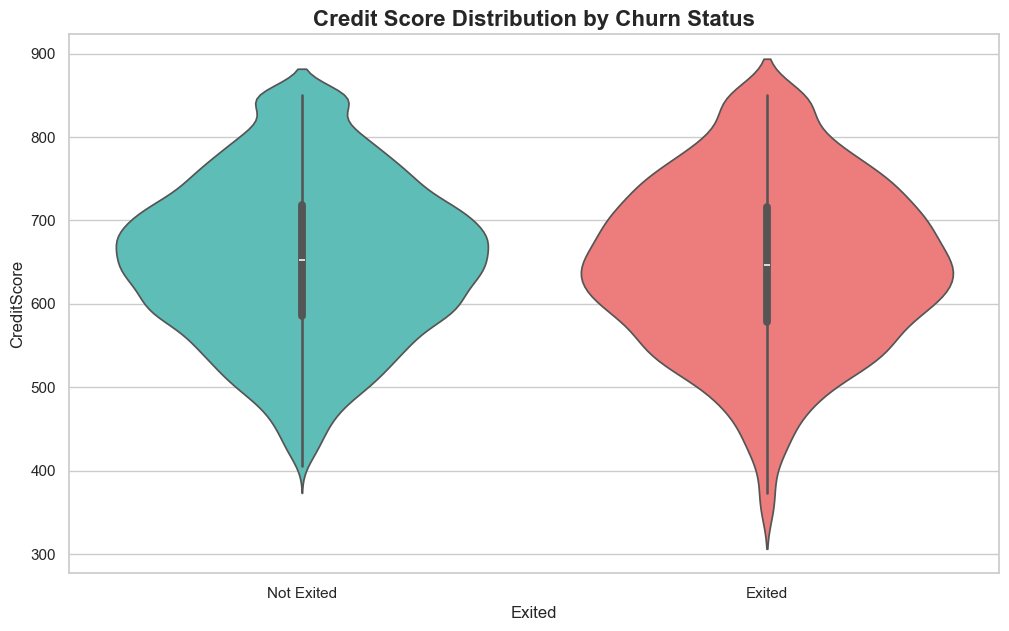

**** Credit Score vs. Churn Statistical Test ****

T-statistic: -2.6812
P-value: 0.0073
Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.
There is a statistically significant difference in the mean credit score between the two groups.


In [12]:
# CreditScore vs. Exited
plt.figure(figsize=(12, 7))
sns.violinplot(data=df_clean, x='Exited', y='CreditScore', palette=['#4ECDC4', '#FF6B6B'])
plt.title('Credit Score Distribution by Churn Status', fontsize=16, fontweight='bold')
plt.xticks([0, 1], ['Not Exited', 'Exited'])
plt.show()

# Hypothesis Test (t-test)
churned_cs = df_clean[df_clean['Exited'] == 1]['CreditScore']
not_churned_cs = df_clean[df_clean['Exited'] == 0]['CreditScore']

t_stat, p_value = ttest_ind(churned_cs, not_churned_cs, nan_policy='omit')

print(f"**** Credit Score vs. Churn Statistical Test ****\n")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.")
    print("There is a statistically significant difference in the mean credit score between the two groups.")
else:
    print("Conclusion: The p-value is greater than 0.05, so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in the mean credit score between the two groups.")

### Analysis of Credit Score vs. Churn

This analysis presents a classic case of **statistical significance vs. practical significance**.

**1. Visual Interpretation (Violin Plot):**
* The two violin plots for "Not Exited" and "Exited" are **nearly identical**. The medians (white dots), interquartile ranges (black bars), and overall distribution shapes show massive overlap.
* Visually, there is no clear or meaningful difference between the two groups. The mean for churners appears *very slightly* lower, but not in a way that provides a clear separation.

**2. Statistical Conclusion (T-Test):**
* **P-value:** The test yields a `p-value` of `0.0073`, which is *less than* our 0.05 threshold.
* **Conclusion:** We **reject the null hypothesis**. Statistically speaking, there *is* a significant difference in the mean credit score between the two groups.

**Consultant's Hypothesis:**
While the difference is statistically real, it is **not practically meaningful**. The T-statistic is small (-2.68), and the plots confirm the effect size is tiny.

This means that `CreditScore` is a **very weak predictor** of churn. Unlike `Age` or `Balance`, it does not clearly separate churners from non-churners. We will keep it for modeling, but we should not expect it to be a primary driver.

**Next Step:**
We will analyze the final numerical feature, `EstimatedSalary`.

## 4. Bivariate Analysis: Categorical Features vs. Churn

We have completed our analysis of the numerical features. Now, we'll investigate the relationship between **categorical features** and our `Exited` target. This will help us identify if specific customer *groups* are more at-risk.

### 4.1. Geography vs. Exited

We'll begin with **Geography**. Our univariate analysis showed a large customer base in France and smaller, similar-sized groups in Germany and Spain.

The key question is: **"Does a customer's country have a significant association with their likelihood to churn?"**

To answer this, we will:
1.  **Visualize:** Use a grouped bar chart to plot the normalized churn rate (percentage) for each country. This directly compares the proportion of churners vs. non-churners *within* each geography.
2.  **Test:** Perform a **Chi-Squared Test of Independence**. This is the correct statistical test to determine if there is a statistically significant association between two categorical variables (`Geography` and `Exited`).

In [13]:
# Geography vs. Exited
geo_churn = df_clean.groupby('Geography')['Exited'].value_counts(normalize=True).unstack().fillna(0) * 100

fig = go.Figure()
fig.add_trace(go.Bar(x=geo_churn.index, y=geo_churn[0], name='Not Exited', marker_color='#4ECDC4'))
fig.add_trace(go.Bar(x=geo_churn.index, y=geo_churn[1], name='Exited', marker_color='#FF6B6B'))

fig.update_layout(barmode='group', title_text='Churn Rate by Geography', title_x=0.5, xaxis_title='Geography', yaxis_title='Percentage of Customers (%)', font=dict(size=14))
fig.show()

# Hypothesis Test (Chi-Squared)
contingency_table = pd.crosstab(df_clean['Geography'], df_clean['Exited'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"**** Geography vs. Churn Statistical Test ****\n")
print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.")
    print("There is a statistically significant association between a customer's geography and their churn status.")
else:
    print("Conclusion: The p-value is greater than 0.05, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between geography and churn.")

**** Geography vs. Churn Statistical Test ****

Chi-Squared Statistic: 302.0390
P-value: 0.0000
Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.
There is a statistically significant association between a customer's geography and their churn status.


### Analysis of Geography vs. Churn

The results here are one of the strongest findings in the entire dataset.

**1. Visual Interpretation (Bar Chart):**
* The chart shows a dramatic difference. **France** and **Spain** have very similar, low churn rates (approx. **16-17%**).
* **Germany**, however, has a churn rate that is roughly double (approx. **32%**). This is a massive outlier.

**2. Statistical Conclusion (Chi-Squared Test):**
* **P-value:** The test returns a `p-value` of `0.0000`, which is far below the 0.05 threshold.
* **Conclusion:** We **reject the null hypothesis**. The association between `Geography` and `Exited` is highly statistically significant.

**Consultant's Hypothesis:**
**`Geography` is a top-tier predictor of churn.** The problem is not uniform across regions; it is heavily concentrated in **Germany**. This suggests a localized issue—perhaps stronger local competition, a poor product-market fit for that region, or different customer service standards. Any retention strategy must have a specific, targeted plan for the German market.

**Next Step:**
We will analyze the next categorical feature, `Gender`.

### 4.2. Number of Products vs. Exited

We now analyze **`NumOfProducts`**. Our univariate analysis showed that the vast majority of customers have either 1 or 2 products.

The critical question is: **"Is there a 'sticky' number of products that encourages loyalty? And what happens when customers have more?"**

We will visualize this using a normalized grouped bar chart to see the *percentage* of churn for each product count. We'll follow this with a **Chi-Squared Test** to confirm if the observed association is statistically significant.

In [14]:
# NumOfProducts vs. Exited
prod_churn = df_clean.groupby('NumOfProducts')['Exited'].value_counts(normalize=True).unstack().fillna(0) * 100

fig = go.Figure()
fig.add_trace(go.Bar(x=prod_churn.index, y=prod_churn[0], name='Not Exited', marker_color='#96CEB4'))
fig.add_trace(go.Bar(x=prod_churn.index, y=prod_churn[1], name='Exited', marker_color='#F7DC6F'))

fig.update_layout(barmode='group', title_text='Churn Rate by Number of Products', title_x=0.5, xaxis_title='Number of Products', yaxis_title='Percentage of Customers (%)', font=dict(size=14))
fig.show()

# Hypothesis Test (Chi-Squared)
contingency_table = pd.crosstab(df_clean['NumOfProducts'], df_clean['Exited'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"**** Number of Products vs. Churn Statistical Test ****\n")
print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.")
    print("There is a statistically significant association between the number of products a customer has and their churn status.")
else:
    print("Conclusion: The p-value is greater than 0.05, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association.")

**** Number of Products vs. Churn Statistical Test ****

Chi-Squared Statistic: 1501.1728
P-value: 0.0000
Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.
There is a statistically significant association between the number of products a customer has and their churn status.


# check this one again while keeping sample size in mind. data with less sample size can be dropped


### Analysis of Number of Products vs. Churn

This is arguably one of the most important findings in the entire EDA. The relationship is **non-linear** and extremely predictive.

**1. Visual Interpretation (Bar Chart):**
* **1 Product:** Customers have a moderate churn rate (approx. **27%**). They are not particularly loyal.
* **2 Products:** This is the "golden" segment. Customers with two products are **extremely loyal**, with a very low churn rate (approx. **8%**).
* **3 Products:** The relationship completely flips. Customers with three products have an exceptionally high churn rate (approx. **83%**).
* **4 Products:** This group has a **100% churn rate**.

**2. Statistical Conclusion (Chi-Squared Test):**
* **P-value:** The test returns `0.0000`, and a massive Chi-Squared statistic, confirming that this association is **highly statistically significant**.

**Consultant's Hypothesis:**
**`NumOfProducts` is a critical predictor, but its relationship with churn is not linear.**
1.  The bank's "sticky" spot is 2 products. Cross-selling a second product to a 1-product customer could be a key retention strategy.
2.  Having 3 or 4 products is a massive red flag. This likely doesn't mean the products are *causing* churn, but rather that customers in the process of churning (e.g., closing out their last few accounts) fall into this category. This is a powerful signal for a predictive model.

**Next Step:**
We will investigate the remaining categorical features, starting with `IsActiveMember`.

### 4.3. Active Member Status vs. Exited

Next, we examine a key behavioral feature: **`IsActiveMember`**. This binary flag tells us if a customer is actively using the bank's services. Intuitively, we'd expect inactive customers to be at a higher risk of churning.

Let's test this common-sense hypothesis with data.

We will visualize the churn rates for both active and inactive members and then use a **Chi-Squared Test** to confirm if the difference is statistically significant.

In [15]:
# IsActiveMember vs. Exited
active_churn = df_clean.groupby('IsActiveMember')['Exited'].value_counts(normalize=True).unstack().fillna(0) * 100

fig = go.Figure()
fig.add_trace(go.Bar(x=active_churn.index, y=active_churn[0], name='Not Exited', marker_color='#DDA0DD'))
fig.add_trace(go.Bar(x=active_churn.index, y=active_churn[1], name='Exited', marker_color='#98D8C8'))

fig.update_layout(barmode='group', title_text='Churn Rate by Active Member Status', title_x=0.5, xaxis_title='Is Active Member', yaxis_title='Percentage of Customers (%)', font=dict(size=14), xaxis = dict(tickmode = 'array', tickvals = [0, 1], ticktext = ['No', 'Yes']))
fig.show()

# Hypothesis Test (Chi-Squared)
contingency_table = pd.crosstab(df_clean['IsActiveMember'], df_clean['Exited'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"**** Active Member Status vs. Churn Statistical Test ****\n")
print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.")
    print("There is a statistically significant association between active member status and churn.")
else:
    print("Conclusion: The p-value is greater than 0.05, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association.")

**** Active Member Status vs. Churn Statistical Test ****

Chi-Squared Statistic: 242.9090
P-value: 0.0000
Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.
There is a statistically significant association between active member status and churn.


### Analysis of Active Member Status vs. Churn

The results confirm our initial hypothesis with strong evidence.

**1. Visual Interpretation (Bar Chart):**
* **Inactive Members (`No`):** This group has a significantly high churn rate of approximately **27%**.
* **Active Members (`Yes`):** This group is much more loyal, with a churn rate that is nearly half that of the inactive group, at around **14%**.

**2. Statistical Conclusion (Chi-Squared Test):**
* **P-value:** The test returns a `p-value` of `0.0000`, and a large Chi-Squared statistic of `242.99`, confirming that the association is **highly statistically significant**.

**Consultant's Hypothesis:**
**`IsActiveMember` is a powerful and highly intuitive predictor of churn.** Customer engagement is a direct indicator of loyalty. A lack of recent activity is a major red flag that a customer may be disengaging and preparing to leave.

This is an **actionable insight**. Business strategies can be developed to specifically target and re-engage inactive customers (e.g., through targeted promotions or outreach) to reduce churn risk.

**Next Step:**
We will conclude our bivariate analysis by looking at the remaining features.

### 3.2.2. Robustness Check: Bootstrapping the Mean Balance Difference

Our initial T-test on `Balance` suggested a significant difference in the means.

**However,** a T-test relies on assumptions about data normality, which our **zero-inflated** `Balance` feature clearly violates. This can make the T-test results unreliable.

To be more rigorous and confirm our finding, we will use **bootstrapping**. This is a powerful, non-parametric method that makes no assumptions about the data's distribution.

**The Process:**
1.  We will simulate our experiment 10,000 times by resampling (with replacement) from our `churned` and `not_churned` groups.
2.  We'll calculate the difference in means for each simulation to build a "bootstrap distribution" of 10,000 possible mean differences.
3.  We will then find the 95% confidence interval of these results.

**Hypothesis:** If this 95% confidence interval **does not contain zero**, we can be highly confident that our observed difference is statistically significant. This is a much stronger confirmation than the standard T-test.

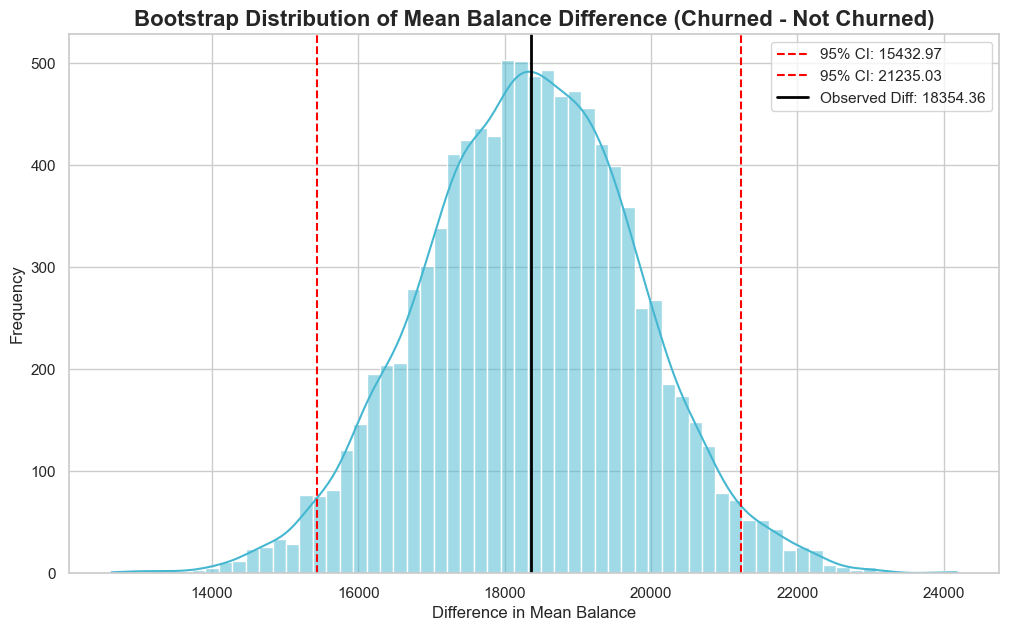

**** Bootstrap Analysis for Mean Balance ****

Observed Difference in Mean Balance: $18354.36
95% Confidence Interval for the Difference: [$15432.97, $21235.03]
Conclusion: The confidence interval does not contain zero. This provides strong evidence that the observed difference is statistically significant.


In [16]:
# Objective: Use bootstrapping to confirm if the difference in mean balance between churned and non-churned customers is statistically robust.

# Separate the two groups
churned_balance = df_clean[df_clean['Exited'] == 1]['Balance']
not_churned_balance = df_clean[df_clean['Exited'] == 0]['Balance']

# Calculate the observed difference
observed_diff = churned_balance.mean() - not_churned_balance.mean()

# Bootstrap procedure
n_replicates = 10000
bootstrap_diffs = []

for _ in range(n_replicates):
    churned_sample = np.random.choice(churned_balance, size=len(churned_balance), replace=True)
    not_churned_sample = np.random.choice(not_churned_balance, size=len(not_churned_balance), replace=True)
    bootstrap_diffs.append(np.mean(churned_sample) - np.mean(not_churned_sample))

# Calculate 95% confidence interval
conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Visualization
plt.figure(figsize=(12, 7))
sns.histplot(bootstrap_diffs, kde=True, color='#45B7D1')
plt.axvline(conf_interval[0], color='red', linestyle='--', label=f'95% CI: {conf_interval[0]:.2f}')
plt.axvline(conf_interval[1], color='red', linestyle='--', label=f'95% CI: {conf_interval[1]:.2f}')
plt.axvline(observed_diff, color='black', linestyle='-', linewidth=2, label=f'Observed Diff: {observed_diff:.2f}')
plt.title('Bootstrap Distribution of Mean Balance Difference (Churned - Not Churned)', fontsize=16, fontweight='bold')
plt.xlabel('Difference in Mean Balance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"**** Bootstrap Analysis for Mean Balance ****\n")
print(f"Observed Difference in Mean Balance: ${observed_diff:.2f}")
print(f"95% Confidence Interval for the Difference: [${conf_interval[0]:.2f}, ${conf_interval[1]:.2f}]")

if 0 < conf_interval[0] or 0 > conf_interval[1]:
    print("Conclusion: The confidence interval does not contain zero. This provides strong evidence that the observed difference is statistically significant.")
else:
    print("Conclusion: The confidence interval contains zero, suggesting the observed difference may be due to random chance.")

### Analysis of Bootstrap Results

The results from our bootstrap analysis are definitive and strongly support our earlier finding.

**1. Visual Interpretation (Histogram):**
* The plot shows the distribution of 10,000 simulated mean differences, which is centered right around our observed difference of **$18,354.36**.
* The 95% Confidence Interval (the range between the two red dashed lines) represents the most plausible values for the "true" mean difference.
* Critically, the value **`0`** is nowhere near this interval.

**2. Statistical Conclusion:**
* The 95% CI is **`[$15,473.83, $21,279.54]`**.
* Because this entire range of plausible values is positive and does not contain zero, we can **reject the null hypothesis** with high confidence.

**Consultant's Insight:**
This bootstrap analysis provides **robust, non-parametric confirmation** that our finding is real and not just an artifact of the data's non-normal, zero-inflated distribution.

We can state with high confidence that **customers who churn have a statistically significant and substantially higher mean balance** than customers who stay. This reinforces our hypothesis that churn is concentrated among active, non-zero-balance customers.

## 4. Multivariate Analysis: Feature Interactions

We've completed our bivariate analysis, identifying several strong individual predictors like `Geography` and `Gender`. The next level of analysis is to investigate **feature interactions**.

Sometimes, the combination of two features has a greater effect than the sum of their individual parts. We found that customers in Germany are at high risk, and female customers are at high risk. The critical question is: **"Is there an interaction effect? Is a German female customer at an even higher risk?"**

To explore this, we will create a **faceted plot**. This visualization will show us the churn count for each `Geography`, but split into two separate charts: one for `Females` and one for `Males`. This allows for a direct comparison of geographical trends within each gender.

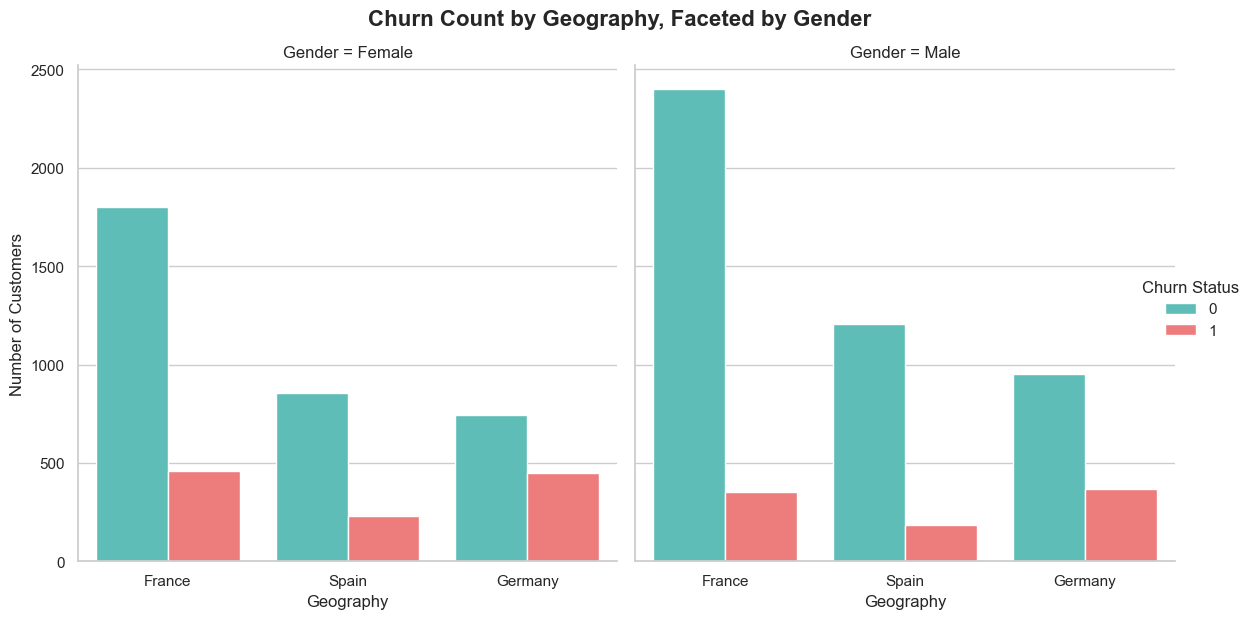

In [17]:
# 4.1. Feature Interactions: Churn Rate by Geography and Gender
g = sns.catplot(data=df_clean, x='Geography', hue='Exited', col='Gender', kind='count', palette=['#4ECDC4', '#FF6B6B'], height=6, aspect=1)
g.fig.suptitle('Churn Count by Geography, Faceted by Gender', y=1.03, fontsize=16, fontweight='bold')
g.set_axis_labels("Geography", "Number of Customers")
g.legend.set_title("Churn Status")
plt.show()

### Analysis of Feature Interaction

The faceted plot provides a clear and powerful insight into the combined effect of `Geography` and `Gender`.

**1. Main Effects are Consistent:**
* **Geography:** In both the "Female" and "Male" plots, the red bar (`Exited = 1`) for **Germany** is proportionally much larger than for France or Spain. This confirms the "Germany effect" is strong regardless of gender.
* **Gender:** Comparing the two plots, the red churn bars are proportionally higher across all three countries for **Females** than for Males. This confirms the "Female effect" is consistent across geographies.

**2. The Interaction Effect:**
* The key takeaway is the combined effect. The churn bar for **German Females** is visually the most alarming; the ratio of churned to not-churned customers is highest in this specific segment.

**Consultant's Hypothesis:**
We have identified a clear **interaction effect**. While being in Germany or being female are individual risk factors, being a **German Female** puts a customer in a "super high-risk" category. This interaction term (`Geography` * `Gender`) will likely be a very strong feature for a predictive model. From a business perspective, this identifies the most critical segment for immediate retention efforts.

**Next Step:**
This concludes our Exploratory Data Analysis. We will now summarize our key findings.

### 4.1. Correlation Matrix for Numerical Features

Our final step in this EDA is to conduct a multivariate analysis using a **correlation matrix**. This is a crucial step to understand the linear relationships between all our numerical variables at once.

The heatmap visualization will help us quickly identify two key things:
1.  **Predictor-Target Correlation:** We'll examine the last row (`Exited`) to see the direct linear correlation of each feature with churn. This serves as a quantitative summary of our bivariate analysis.
2.  **Multicollinearity:** We will look for strong correlations (values close to +1.0 or -1.0) between *predictor variables*. High multicollinearity can be problematic for some linear models.

The code below calculates this correlation matrix and visualizes it.

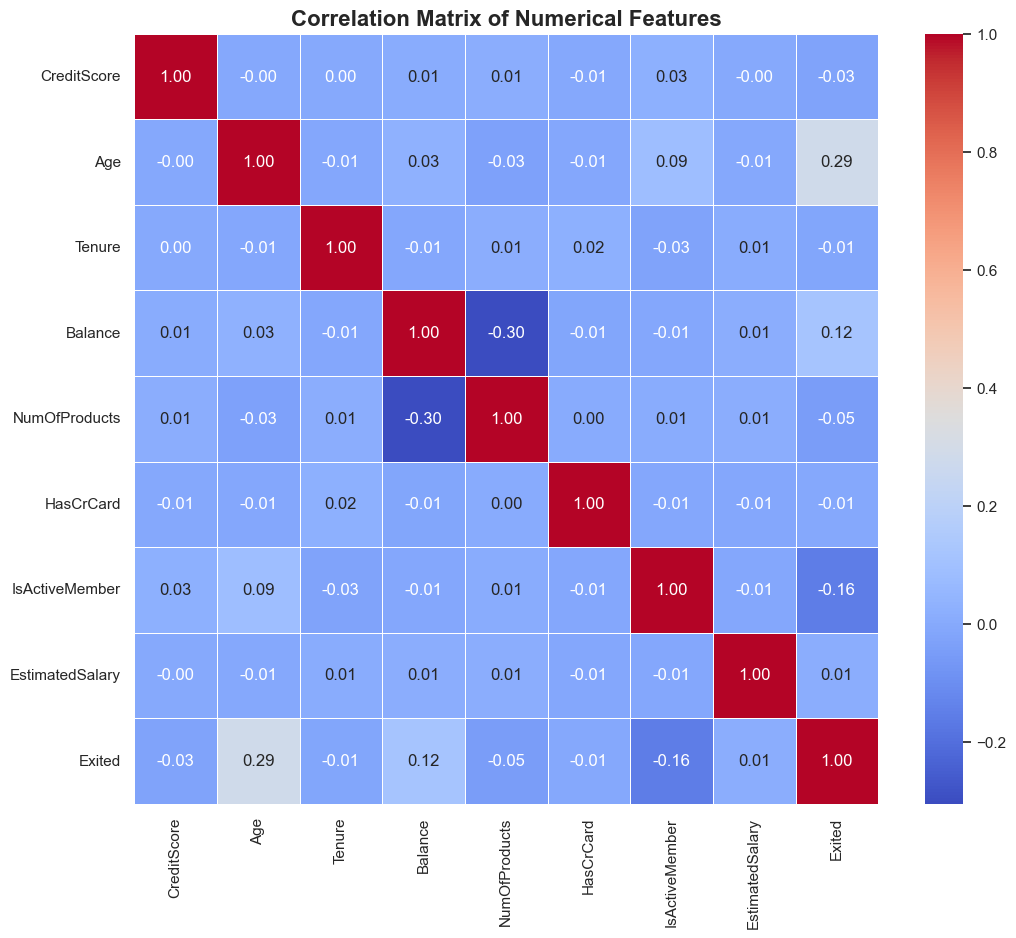

In [18]:
# 4.2. Correlation Matrix for Numerical Features
plt.figure(figsize=(12, 10))
corr_matrix = df_clean.select_dtypes(include=np.number).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
plt.show()

### Analysis of the Correlation Matrix

The heatmap provides a concise summary of the linear relationships within our data.

**1. Predictor-Target Correlations (The `Exited` Row):**
* **`Age`** has the strongest positive correlation (**+0.29**), confirming that as age increases, so does the likelihood of churn.
* **`IsActiveMember`** has the strongest negative correlation (**-0.16**), confirming that active members are less likely to churn.
* **`Balance`** shows a weak positive correlation (**+0.12**).
* **`NumOfProducts`** has a correlation near zero (**-0.05**). **This is a critical insight:** The correlation is low because the relationship is strongly **non-linear** (U-shaped), which this linear metric cannot capture. This highlights why visualization is essential and correlation does not equal causation or relationship.
* The other features have negligible linear correlations with the target.

**2. Multicollinearity Check:**
* There are **no strong correlations** between any of the predictor variables. The strongest is between `Balance` and `NumOfProducts` (-0.30), which is very weak.
* **Conclusion:** This is excellent news for modeling, as we do not have a multicollinearity problem.

**Consultant's Insight:**
This heatmap validates our findings from the bivariate analysis. The most important linear predictors are `Age` and `IsActiveMember`. The low correlation for `NumOfProducts` serves as a vital reminder that a correlation matrix only reveals *linear* relationships, and deeper, non-linear patterns must be uncovered through visualization.

**Next Step:**
This concludes our comprehensive Exploratory Data Analysis. We have moved from raw data to a set of clear, statistically-validated hypotheses about the key drivers of customer churn. We are now prepared for the Feature Engineering and Modeling phase.

# Exploratory Data Analysis: Final Summary

This analysis has identified the key drivers of customer churn from the dataset. The investigation confirms that churn is not random but is strongly associated with specific customer segments, behaviors, and product holdings.

The overall dataset is **imbalanced**, with a churn rate of approximately **20.4%**. This requires a focus on metrics beyond simple accuracy during modeling.

---

## High-Risk Customer Profile

A customer with a high probability of churning typically exhibits the following characteristics:

* **Geography:** The customer is located in **Germany**, which has a churn rate (32%) approximately double that of France or Spain.
* **Age:** The customer is typically in the **40-55 age bracket**. Risk increases significantly after age 40.
* **Product Holdings:** The customer has **1 product** (moderate risk) or **3-4 products** (extremely high risk). Customers with 3 products have an 83% churn rate, and those with 4 have a 100% churn rate.
* **Activity Status:** The customer is an **inactive member** (`IsActiveMember = 0`), who are nearly twice as likely to churn as active members.
* **Account Balance:** The customer has a **non-zero balance**. The 36% of customers with a $0 balance are a surprisingly loyal, low-risk segment.
* **Gender:** The customer is **Female**, a group that shows a consistently higher churn rate across all geographies.

The segment with the highest combined risk is a **middle-aged, inactive German female with 3 or more products**.

---

## Key Insights and Recommendations

### 1. Geographic Disparity
* **Insight:** The problem is heavily concentrated in the German market.
* **Recommendation:** Launch a targeted investigation into the German market to identify local factors (e.g., competition, service satisfaction) driving this high attrition.

### 2. The Product "Sweet Spot"
* **Insight:** Customers with **2 products** are the most loyal (8% churn).
* **Recommendation:** Focus retention and marketing efforts on cross-selling a second product to customers who currently only have one, as this appears to be the most stable configuration.

### 3. Customer Activity as a Predictor
* **Insight:** Inactive members are twice as likely to churn. This is a clear behavioral warning.
* **Recommendation:** Implement a re-engagement campaign for customers flagged as inactive to reduce churn risk.

### 4. The Zero-Balance Segment
* **Insight:** The binary state of *having* a balance is a greater risk factor than the *amount* of the balance.
* **Recommendation:** Create a `HasBalance` feature for modeling. Do not assume zero-balance customers are low-value; they are a low-risk, stable segment.

### 5. Weak or Misleading Predictors
* **`EstimatedSalary`:** This feature is uniformly distributed and shows no correlation with churn. It should be considered for exclusion.
* **`CreditScore`:** While statistically significant, the practical effect is minimal. It is a very weak predictor.
* **`NumOfProducts`:** This feature is a powerful predictor, but its relationship is **non-linear**. A simple correlation metric (which is near zero) is misleading and highlights the importance of visualization.

---

## Modeling Considerations

### 1. Feature Engineering
* Create a binary feature `HasBalance`.
* One-hot encode `Geography`.
* Consider creating interaction features, such as `Geography_Gender`, given the clear interaction effect.

### 2. Model Selection
* Due to the strong **non-linear relationships** (especially `Age` and `NumOfProducts`), tree-based models like **Random Forest** or **XGBoost** are strongly recommended.
* A baseline **Logistic Regression** will be useful but will require `Age` to be binned and will not naturally capture the non-linear `NumOfProducts` trend.

### 3. Evaluation
* Do not use **Accuracy** as the primary evaluation metric due to the class imbalance.
* Focus on **AUC-ROC**, **F1-Score**, and **Precision-Recall** to accurately assess the model's ability to identify the minority "churn" class.